In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('../data/LaFleur_supp.csv')
df['Normalized Observed log(TX/Txref)'] = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']])

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

def split_data_by_file(df):

    # Get the unique file names
    file_names = df['File Name'].unique()

    # Split the data by file
    split_data = {name: {} for name in file_names}
    split_data['all'] = {}

    # Preprocess the data, split for each file
    for file in file_names:
        filtered_df = df[df['File Name'].isin([file])]
        X, y = combine_columns(filtered_df)
        X = preprocess_sequences(X, 150)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        split_data[file]['X_train'] = X_train
        split_data[file]['X_test'] = X_test
        split_data[file]['y_train'] = y_train
        split_data[file]['y_test'] = y_test

    # Preprocess the data, include all files
    X, y = combine_columns(df)
    X = preprocess_sequences(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    split_data['all']['X_train'] = X_train
    split_data['all']['X_test'] = X_test
    split_data['all']['y_train'] = y_train
    split_data['all']['y_test'] = y_test

    return split_data, file_names

def combine_columns(df):
    X = df[['Promoter Sequence']].astype(str).agg(''.join, axis=1)
    y = df['Normalized Observed log(TX/Txref)']
    return X, y

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

def padded_one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], '0': [0, 0, 0, 0]}
    return np.array([mapping[nucleotide.upper()] for nucleotide in sequence])

split_data, file_names = split_data_by_file(df)

In [ ]:
from itertools import combinations, chain
from keras.models import Sequential, load_model # type: ignore
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense # type: ignore
from keras.optimizers import Adam # type: ignore

def evaluate_file_combinations(file_names, split_data):

    # Generate all combinations of file_names
    all_combinations = list(chain.from_iterable(combinations(file_names, i) for i in range(1, len(file_names) + 1)))

    # Store the number of files and corresponding loss for plotting
    data_for_plot = []

    # Create a model for each combination of files
    for i, file_combo in enumerate(all_combinations):
        print(f'Training model {i}/{len(all_combinations)} with files: {file_combo}', end='\r')
        combined_X_train = np.concatenate([split_data[file_name]['X_train'] for file_name in file_combo], axis=0)
        combined_y_train = np.concatenate([split_data[file_name]['y_train'] for file_name in file_combo], axis=0)
        
        file_combo_str = ', '.join(file_combo)
        
        # Make model and get MSE
        model, history, loss = run(combined_X_train,
                                               combined_y_train,
                                               split_data['all']['X_test'],
                                               split_data['all']['y_test'],
                                               file_combo_str)
        
        # Record the number of files and the loss
        data_for_plot.append((len(file_combo), np.log(loss), file_combo_str))

    return data_for_plot


def run(X_train, y_train, X_test, y_test, model_name, epochs=100, batch_size=32):
    model = build_cnn_model(X_train.shape[1:])
    history = train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size)
    loss = evaluate_model(model, X_test, y_test)

    return model, history, loss

def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=0
    )
    return history

def evaluate_model(model, X_test, y_test):
    loss = model.evaluate(
        X_test, y_test,
        verbose=0
    )
    return loss

def save_data_for_plot_to_csv(data_for_plot, filename='data/multiple_files_data_comparison.csv'):
    df = pd.DataFrame(data_for_plot)
    df.columns = ['Number of Files', 'MSE', 'Name']
    df.to_csv(filename, index=False)

In [5]:
# Trains a model for each file combination and saves the data for the plot. Takes days to run.

# data_for_plot = evaluate_file_combinations(file_names, split_data)
# save_data_for_plot_to_csv(data_for_plot)

In [ ]:
data_for_plot = pd.read_csv('../data/multiple_files_data_comparison.csv').values

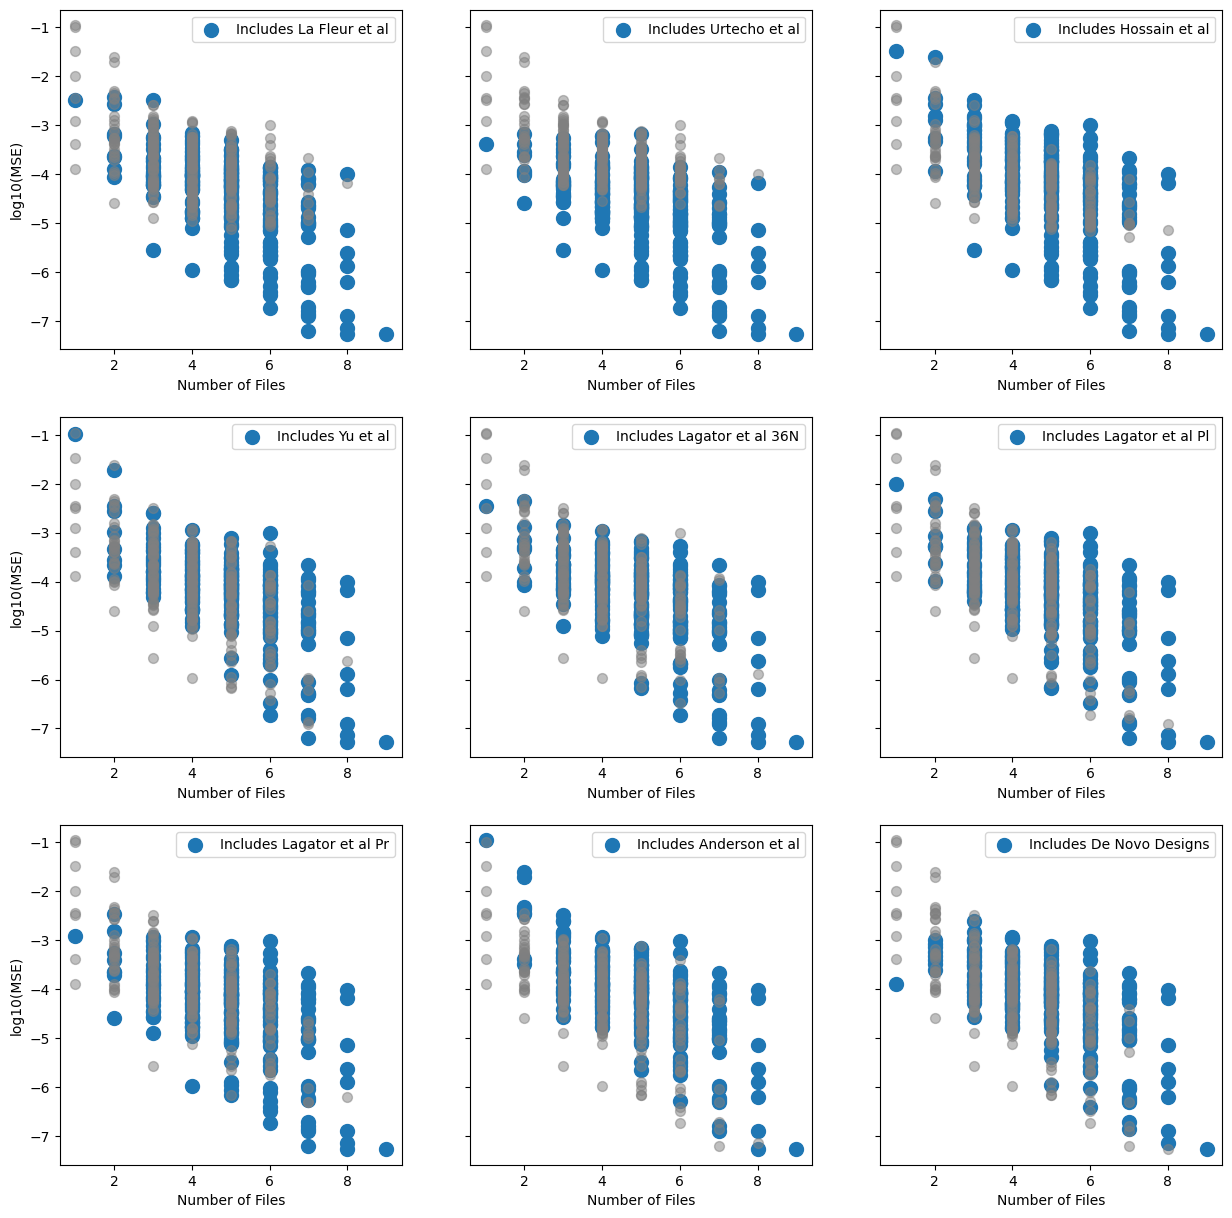

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract data for plotting
num_files = [entry[0] for entry in data_for_plot]
loss_values = [entry[1] for entry in data_for_plot]
file_combos = [entry[2] for entry in data_for_plot]

# Create a 3x3 grid for 9 files
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Loop through each file and plot it in a grid cell
for i, file_name in enumerate(file_names):
    row, col = divmod(i, 3)  # Determine the row and column in the grid
    ax = axs[row, col]  # Select the corresponding subplot
    
    # Separate data based on whether the current file is included or not
    included_points = [(n, l) for (n, l, combo) in data_for_plot if file_name in combo]
    not_included_points = [(n, l) for (n, l, combo) in data_for_plot if file_name not in combo]
    
    # Plot included points in color
    if included_points:
        num_files_included, loss_included = zip(*included_points)
        ax.scatter(num_files_included, loss_included, label=f'Includes {file_name}', color='tab:blue', s=100)
    
    # Plot not included points in grey
    if not_included_points:
        num_files_not_included, loss_not_included = zip(*not_included_points)
        ax.scatter(num_files_not_included, loss_not_included, color='grey', s=50, alpha=0.5)
    
    # Set plot details for the current subplot
    ax.set_xlabel('Number of Files')
    if i % 3 == 0:
        ax.set_ylabel('log10(MSE)')
    else:
        ax.set_yticklabels([])
    ax.legend()

plt.show()

3 Files: t-stat = -5.4735, p = 0.0000 (Significant)
4 Files: t-stat = -8.0197, p = 0.0000 (Significant)
5 Files: t-stat = -7.5630, p = 0.0000 (Significant)
6 Files: t-stat = -9.8354, p = 0.0000 (Significant)


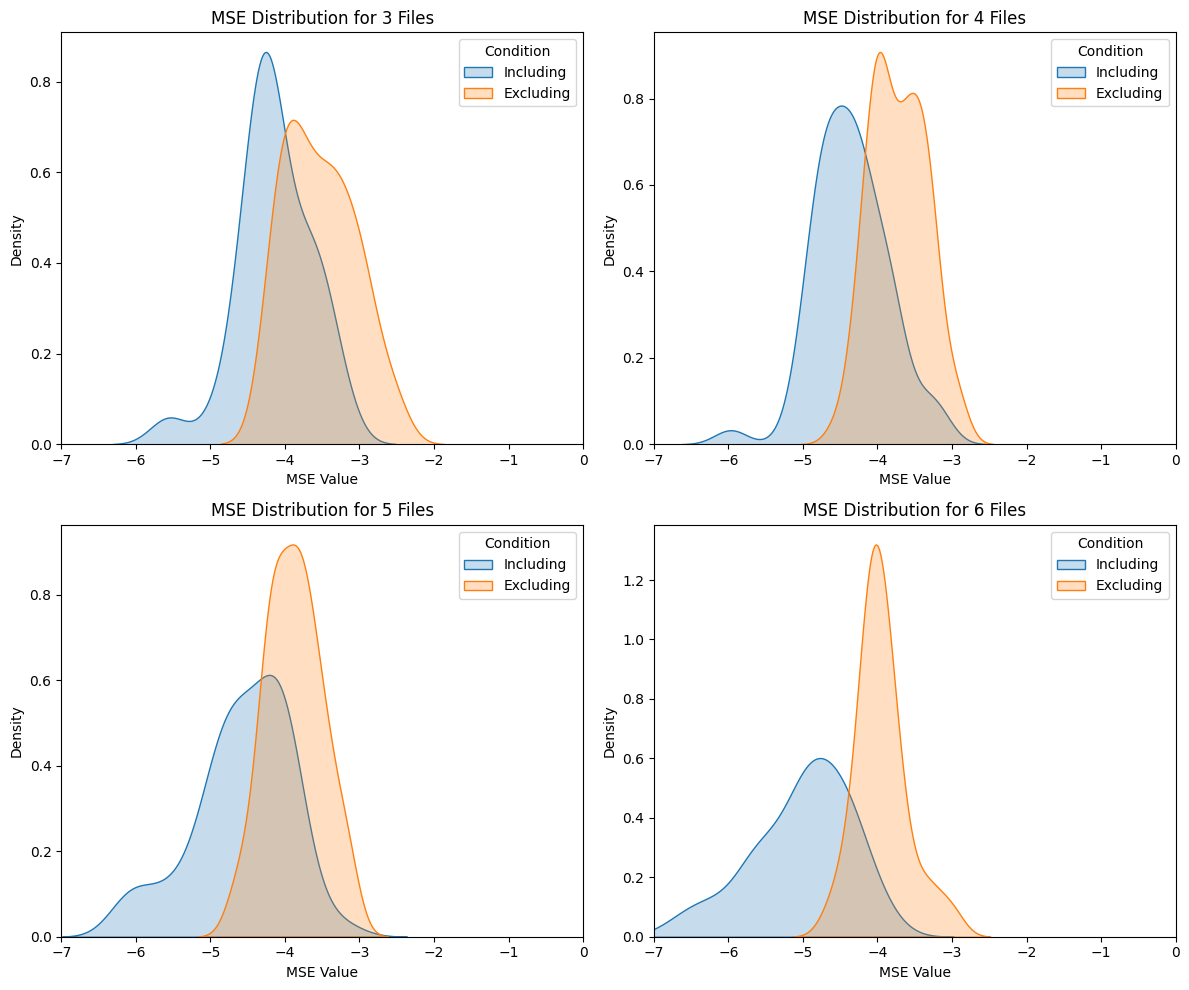

In [8]:
from scipy.stats import ttest_ind

def get_file_mse_effect(file_names, data_for_plot):
    all_combinations = list(chain.from_iterable(combinations(file_names, i) for i in range(1, len(file_names) + 1)))
    file_mse = {tuple(sorted(each)) : None for each in all_combinations}
    for each in data_for_plot:
        key = tuple(sorted(each[2].split(', ')))
        file_mse[key] = each[1]

    mse_effect = {file : [] for file in file_names}

    for key, value in file_mse.items():
        for file in file_names:
            if file in key:
                continue
            next_key = tuple(sorted(key + (file,)))
            mse_difference = value - file_mse[next_key]
            mse_effect[file].append(mse_difference)
    
    return file_mse, mse_effect

def plot_mse_distribution_with_ttest(file_names, data_for_plot, file_of_interest, start_from=1, end_at=None):

    file_mse, mse_effect = get_file_mse_effect(file_names, data_for_plot)

    include_mse_values = []
    exclude_mse_values = []

    for key, value in file_mse.items():
        if file_of_interest in key:
            include_mse_values.append((len(key), value))
        else:
            exclude_mse_values.append((len(key), value))

    include_mse_by_num_files = {i: [] for i in range(1, len(file_names) + 1)}
    exclude_mse_by_num_files = {i: [] for i in range(1, len(file_names) + 1)}

    for num_files, mse_value in include_mse_values:
        include_mse_by_num_files[num_files].append(mse_value)

    for num_files, mse_value in exclude_mse_values:
        exclude_mse_by_num_files[num_files].append(mse_value)

    end_at = end_at or len(file_names) - 1

    num_plots = end_at - start_from + 1
    n_cols = 2
    n_rows = (num_plots + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))

    axes = axes.flatten()

    for idx, i in enumerate(range(start_from, end_at + 1)):
        include_mse = include_mse_by_num_files[i]
        exclude_mse = exclude_mse_by_num_files[i]

        # Perform T-test if both distributions have enough data
        if len(include_mse) > 1 and len(exclude_mse) > 1:
            t_stat, p_value = ttest_ind(include_mse, exclude_mse, equal_var=False)
            significance = " (Significant)" if p_value < 0.05 else ""
            print(f"{i} Files: t-stat = {t_stat:.4f}, p = {p_value:.4f}{significance}")
        else:
            print(f"{i} Files: Not enough data for t-test.")

        sns.kdeplot(include_mse, label='Including', fill=True, warn_singular=False, ax=axes[idx])
        sns.kdeplot(exclude_mse, label='Excluding', fill=True, warn_singular=False, ax=axes[idx])

        axes[idx].set_title(f'MSE Distribution for {i} Files')
        axes[idx].set_xlabel('MSE Value')
        axes[idx].set_ylabel('Density')

        # Set x-axis limits
        axes[idx].set_xlim(-7, 0)

        axes[idx].legend(title='Condition')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

plot_mse_distribution_with_ttest(file_names, data_for_plot, 'Urtecho et al', start_from=3, end_at=6)
